In [18]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm
import pprint

THEANO_FLAGS = 'exception_verbosity=high'
THEANO_FLAGS='optimizer=fast_compile'
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'

# Test 1: Scalar ODE with 1 parameter

$$ y' = exp(-t) - \alpha y \quad y(0) = 0 $$

In [3]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_odeparams = 1

#Times to evaluate the solution
data = make_test_data_1()
times = data['t']
# times = np.arange(0.25,8,0.25)

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_1, 
                    t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

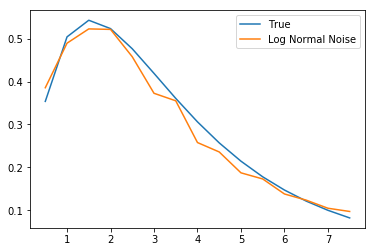

In [9]:

Ytrue = data['y']
Y = data['yobs']

plt.plot(times, Ytrue, label = 'True')
plt.plot(times, Y, label = 'Log Normal Noise')

plt.legend()

In [11]:
my_ODEop = ODEop(ode_model)

In [13]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    alpha = pm.HalfNormal('alpha',1)

    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    # [ODE parameter, Initial Condition]
    all_params = pm.math.stack([alpha, 0],axis=0)

    
    ode_sol = my_ODEop(all_params)

    forward = ode_sol.reshape(Y.shape)
    
    ode = pm.Deterministic('ode',ode_sol)
        
    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
    
    trace = pm.sample(2000, tune=1000, init='adapt_diag', target_accept = 0.99)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [04:11<00:00, 17.36draws/s]


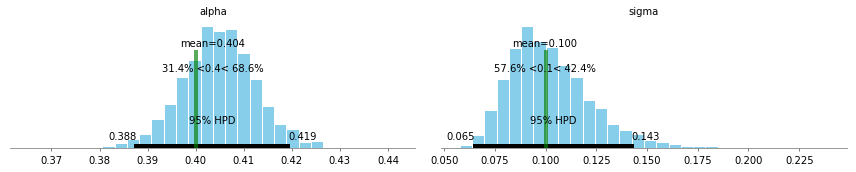

In [17]:
alpha = data['p'][0]
y0 = 0
sigma = data['sigma']
pm.posteriorplot.plot_posterior(trace,varnames = ['alpha','sigma'], ref_val=[alpha, sigma]);

In [21]:
pprint.pprint(pm.gelman_rubin(trace))

pprint.pprint(pm.effective_n(trace))

{'alpha': 0.999982466364655,
 'ode': array([0.99998146, 0.9999804 , 0.9999793 , 0.99997815, 0.99997695,
       0.99997572, 0.99997446, 0.99997316, 0.99997183, 0.99997047,
       0.99996909, 0.99996768, 0.99996625, 0.99996479, 0.99996332]),
 'sigma': 0.9998625983276902}
{'alpha': 2619.3528264244314,
 'ode': array([2617.19390867, 2614.90860503, 2612.50068831, 2609.97440608,
       2607.33427581, 2604.5849551 , 2601.7311394 , 2598.77744674,
       2595.72833435, 2592.58806317, 2589.36064127, 2586.04978853,
       2582.65889775, 2579.1912013 , 2575.64963087]),
 'sigma': 2668.648394871284}


In [23]:
with first_model:
    ppc = pm.sample_ppc(trace, 2000)

/Users/demetri/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 2000/2000 [00:35<00:00, 56.71it/s]


Text(0.5, 1.0, 'Posterior Predictive Check')

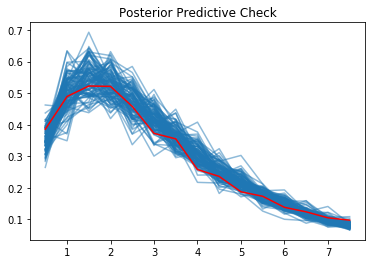

In [25]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5);
    
plt.plot(times,Y, color = 'red');
plt.title('Posterior Predictive Check')

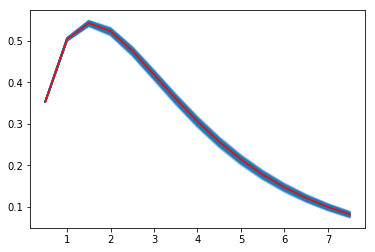

In [28]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.25);
    
plt.plot(times,Ytrue, color = 'red');